# Overview🧬 

Protein Secondary Structure Prediction
Predicting the secondary structure of proteins is a central problem in computational biology. The way a protein folds—forming helices, sheets, and loops—determines its function, stability, and interactions. In this Kaggle competition, the goal is to automatically infer the secondary structure of peptide sequences, making it a sequence-to-sequence prediction task where input and output sequences share the same length.

This challenge uses a curated dataset of peptide sequences paired with their experimentally determined secondary structures in two annotation schemes:

- Q8 (sst8) — Eight-state secondary structure labels
- Q3 (sst3) — A simplified three-state version commonly used in structure prediction
The competition encourages participants to build models that map an amino-acid sequence (e.g., "ACDEFGHIK") to its corresponding structural sequence.

It is also encouraged to use bidirectional sequence-to-sequence model.

# Setup

In [1]:
!pip install trackio -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 110.6 MB/s eta 0:00:00


## Libraries and imports

In [2]:
import os
from typing import List, Dict, Tuple
from collections import Counter

import numpy as np
import pandas as pd

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchmetrics
from sklearn.metrics import f1_score

from tqdm import tqdm
import matplotlib.pyplot as plt
import trackio

In [3]:
# Huggingface Access Adding token to environment variable
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
import os
os.environ['HF_TOKEN']  = user_secrets.get_secret("hf_token")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data Loaders/ Lightning DataModule

In [5]:
train = pd.read_csv('/kaggle/input/sep-25-dl-gen-ai-nppe-2/train.csv')
test = pd.read_csv('/kaggle/input/sep-25-dl-gen-ai-nppe-2/test.csv')

In [6]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head(2)

Train shape: (7262, 4)
Test shape: (1816, 2)


,id,seq,sst8,sst3
0,0,GVGLEGGVQLSPARTRGPEFAAPEQAG,CCCCCCCCSCCCCCCGGGCCCCCCCCC,CCCCCCCCCCCCCCCHHHCCCCCCCCC
1,1,NHGKVKIEHTKWNVEYKVTYNRNVFANHIRSGELASNGYHTTRRTA...,CEEEEEECCTTTEEEEEEEEEEEEEEEEEEEEECSCCSSSCCCCEE...,CEEEEEECCCCCEEEEEEEEEEEEEEEEEEEEECCCCCCCCCCCEE...


## Basic EDA

Train sequence length: min 20, max 1632, median 207.0
Test sequence length: min 20, max 1174, median 215.0


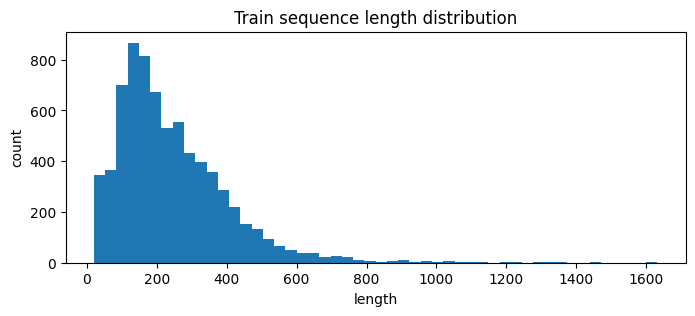

,id,seq,sst8,sst3,seq_len
7114,7114,VTKELNLSQEVKKKASEYDRKMAETANDGEIDLVKKYAELAEEPKG...,CCCCTHHHHHHHHHHHHHHHHHHHCCGGGHHHHHHHHHHHHHHHCT...,CCCCCHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHCC...,140
479,479,FFLTRDAELTLDILTSGGVLEIGEVVDDEKMHCMDKLSQVCVYMKV...,CEEEESSHHHHHHHHHTCEEECTTCBGGGCCCTTHHHHHHEEEEEC...,CEEEECCHHHHHHHHHCCEEECCCCEHHHCCCCCHHHHHHEEEEEC...,134
6184,6184,QKRQQLTYTLPSWASSGSSTTAYQYLSMQQRGTVIGGVVAQGLNDR...,CCEEEEECCEEECCCEETTEEEEEEEEEETTEEEEEEEEEECBTTB...,CCEEEEECCEEECCCEECCEEEEEEEEEECCEEEEEEEEEECECCE...,210
3983,3983,NELHDVIATLALPKGCKECVRYQIPKDLPDEILQANPNFYKKLSER...,CCCCTTTGGGCEECCTTTEEECCCSSSTTSSCCCCTTCBHHHHHHH...,CCCCCCCHHHCEECCCCCEEECCCCCCCCCCCCCCCCCEHHHHHHH...,96
6967,6967,RLRGDPKVAGLESKPDPSFSSWATQSCTQMVPCATPGTACIDMATW...,CCCSTTCCCCCCGGGCCSTTSSSSGGGEECTTCSCCSSEEEEEEEE...,CCCCCCCCCCCCHHHCCCCCCCCCHHHEECCCCCCCCCEEEEEEEE...,751


In [7]:
''' Calculate the sequence lenght of both train/test dataset '''

train['seq_len'] = train['seq'].str.len()
test['seq_len'] = test['seq'].str.len()

print("Train sequence length: min {}, max {}, median {:.1f}".format(
    train['seq_len'].min(), train['seq_len'].max(), train['seq_len'].median()))
print("Test sequence length: min {}, max {}, median {:.1f}".format(
    test['seq_len'].min(), test['seq_len'].max(), test['seq_len'].median()))


''' Plotting the distribution on the sequence legnht '''

plt.figure(figsize=(8,3))
plt.hist(train['seq_len'], bins=50)
plt.title("Train sequence length distribution")
plt.xlabel("length")
plt.ylabel("count")
plt.show()


''' Show 5 samples of train set'''

train.sample(5)[['id','seq','sst8','sst3','seq_len']]

In [8]:
# Special tokens

# Token used for padding shorter sequences
PAD = "<pad>"

# Token used for unknown amino acids
UNK = "<unk>"


'''building Amino acid vocabulary  ''' 

# List of 20 standard amino acids
AA = []

amino_string = "ACDEFGHIKLMNPQRSTVWY"

# Add each amino acid one by one
for a in amino_string:
    AA.append(a)

# Add special masked character
AA.append("*")


# Final amino acid vocabulary
AA_VOCAB = []

# Add padding and unknown tokens first
AA_VOCAB.append(PAD)
AA_VOCAB.append(UNK)

# Add all amino acids
for a in AA:
    AA_VOCAB.append(a)

''' Amino acid with index mapping ''' 

# Map amino acid → index
aa2idx = {}
index = 0

for char in AA_VOCAB:
    aa2idx[char] = index
    index += 1


# Map index → amino acid
idx2aa = {}

for key in aa2idx:
    idx = aa2idx[key]
    idx2aa[idx] = key

''' Q8 secondary structure labels '''


# Q8 labels
Q8 = ['H','G','I','E','B','T','S','C']

# Map Q8 label to index
q8_to_idx = {}
index = 0

for label in Q8:
    q8_to_idx[label] = index
    index += 1

# Map index to Q8 label
idx_to_q8 = {}

for key in q8_to_idx:
    idx = q8_to_idx[key]
    idx_to_q8[idx] = key

''' Q8 to Q3 conversion rules '''


# Mapping from Q8 states to Q3 states
Q8_TO_Q3 = {
    'H':'H','G':'H','I':'H',
    'E':'E','B':'E',
    'C':'C','S':'C','T':'C'
}

''' Q3 labels '''


# Q3 classes
Q3 = ['H','E','C']

# Map Q3 label to index
q3_to_idx = {}
index = 0

for label in Q3:
    q3_to_idx[label] = index
    index += 1


''' Ignore index for loss masking '''


# Used in loss functions to ignore padded positions
IGNORE_INDEX = -100


In [9]:
''' Convert amino acid sequence to indices '''

def seq_to_idx(seq):
    # This list will store index values
    indices = []

    # Go through each character in the sequence
    for c in seq:
        # If amino acid exists in vocabulary, use its index
        if c in aa2idx:
            indices.append(aa2idx[c])
        else:
            # Otherwise use UNK token index
            indices.append(aa2idx[UNK])

    return indices


''' Convert label sequence to indices '''

def lab_to_idx(ls, mapping):
    # This list will store label indices
    indices = []
    # Go through each label in the sequence
    for c in ls:
        # Convert label to index using provided mapping
        indices.append(mapping[c])
    return indices


In [10]:
'''This is a custom Dataset for training data, and it is used together with PyTorch’s DataLoader'''

class ProteinDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.loc[i]
        seq = torch.tensor(seq_to_idx(r['seq']), dtype=torch.long)
        y8  = torch.tensor(lab_to_idx(r['sst8'], q8_to_idx), dtype=torch.long)
        return seq, y8

In [11]:
'''collate_fn pads variable length protein sequences into fixed-size batches,
creates masks for valid residues, and ensures padded labels are ignored during loss computation.'''

def collate_fn(batch):
    maxlen = max(len(b[0]) for b in batch)        # longest sequence length in batch
    B = len(batch)                                # batch size

    seqs = torch.full((B, maxlen), aa2idx[PAD], dtype=torch.long)   # padded input sequences
    mask = torch.zeros((B, maxlen), dtype=torch.bool)               # mask for real tokens
    y8   = torch.full((B, maxlen), IGNORE_INDEX, dtype=torch.long)  # padded Q8 labels

    for i, (s, a) in enumerate(batch):            # loop over batch samples
        L = len(s)                                # length of current sequence
        seqs[i, :L] = s                           # copy real sequence
        mask[i, :L] = 1                           # mark valid positions
        y8[i, :L]   = a                           # copy real labels

    return seqs, mask, y8                         # return padded batch


In [12]:
''' It takes raw protein data, splits it into training and validation parts, and creates loaders that feed padded batches to the model '''

dataset = ProteinDataset(train)       # create dataset from training dataframe

val_size = int(0.05 * len(dataset))       # take 5% data for validation
train_size = len(dataset) - val_size     # rest of remaining data for training

train_ds, val_ds = random_split(      # split dataset into train and val
    dataset, 
    [train_size, val_size]
)

train_loader = DataLoader(      # dataloader for training
    train_ds,
    batch_size=32,               # number of samples per batch
    shuffle=True,      
    collate_fn=collate_fn        # pad sequences and create mask
)
    
val_loader = DataLoader(       # dataloader for validation
    val_ds,
    batch_size=32,               # same batch size
    shuffle=False,                                        
    collate_fn=collate_fn     # same collate function
)

print("Train:", len(train_ds), "Val:", len(val_ds))

Train: 6899 Val: 363


# Model Architecture

## Model 1: Bidirectional Vanilla RNN

In [13]:
'''This  bidirectional Vanilla RNN model that reads protein sequences in both forward and backward directions 
   to capture contextual informationaround each amino acid.The learned representations are passed through a linear 
   layer to predict Q8 secondary structure labels for every residue in the sequence.
'''

class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()   

        self.embedding = nn.Embedding(  # embedding layer
            vocab_size,                 # vocabulary size
            embed_dim,                  # embedding dimension
            padding_idx=aa2idx[PAD]    # ignore padding token
        )

        self.rnn = nn.RNN(    # RNN layer definition
            embed_dim,        # input size
            hidden_dim,       # hidden state size
            num_layers=2,        # number of RNN layers
            batch_first=True,    # batch dimension first
            bidirectional=True,   # forward + backward RNN
            dropout=0.5         # dropout between layers
        )

        self.dropout = nn.Dropout(0.5)       # dropout for regularization
        self.fc = nn.Linear(hidden_dim * 2, 8)  # map to 8 Q8 classes

    def forward(self, x):
        x = self.embedding(x)    # convert indices to vectors
        out, _ = self.rnn(x)     # pass through BiRNN
        out = self.dropout(out)    # apply dropout
        logits = self.fc(out)    # get class scores
        return logits           # output logits (Batch size, Sequence length, Number of classes (Q8))


## Model 2: Bidirectional LSTM/GRU

In [14]:
'''' Bidirectional  Gated Recurrent Unit ( GRU ) '''

class BiGRU(nn.Module):
    def __init__(self):
        super().__init__()

        self.emb = nn.Embedding(     # embedding layer
            len(AA_VOCAB),          # vocabulary size
            128,                     # embedding dimension
            padding_idx=aa2idx[PAD]  # ignore the padding token
        )

        self.gru = nn.GRU(         # initalise the GRU layer
            input_size=128,        # input feature size
            hidden_size=256,       # hidden state size
            num_layers=2,          # number of GRU layers
            bidirectional=True,    # forward + backward GRU
            batch_first=True,      # batch dimension first
            dropout=0.6           # dropout between layers
        )

        self.dropout = nn.Dropout(0.6)  # dropout for regularization
        self.fc = nn.Linear(256 * 2, 8) # map to 8 Q8 classes

    def forward(self, x):
        x = self.emb(x)       # convert indices to vectors (B, L, 128)
        x, _ = self.gru(x)      # pass through BiGRU (B, L, 512)
        x = self.dropout(x)   # apply dropout
        return self.fc(x)     # output logits (Batch size, Sequence length, Number of classes (Q8))


In [15]:
# class BiLSTM(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.emb = nn.Embedding(     # embedding layer
#             len(AA_VOCAB),           # vocabulary size
#             128,                     # embedding dimension
#             padding_idx=aa2idx[PAD]  # ignore the padding token
#         )

#         self.lstm = nn.LSTM(   # LSTM layer defination
#             input_size=128,      # input feature size
#             hidden_size=384,      # hidden state size
#             num_layers=2,         # number of LSTM layers
#             bidirectional=True,   # forward + backward LSTM
#             batch_first=True,     # batch dimension first
#             dropout=0.3         # dropout between layers
#         )

#         self.dropout = nn.Dropout(0.3)   # dropout for regularization
#         self.fc = nn.Linear(384 * 2, 8)  # map to 8 Q8 classes

#     def forward(self, x):
#         x = self.emb(x)          # convert indices to vectors (B, L, 128)
#         x, _ = self.lstm(x)      # pass through BiLSTM (B, L, 768)
#         x = self.dropout(x)      # apply dropout
#         return self.fc(x)        # output logits (B, L, 8)


In [16]:
model = BiRNN(len(AA_VOCAB)).to(device)

# Loss Function, Optimizer, and Metrics

In [17]:

criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

In [18]:
''' Convert Q8 label predictions to Q3 labels while ignoring padded positions '''

def q8_to_q3_preds(q8_array):
    q3_array = np.full_like(q8_array, IGNORE_INDEX)

    for i in range(q8_array.shape[0]):
        for j in range(q8_array.shape[1]):
            if q8_array[i, j] == IGNORE_INDEX:
                continue

            q8_label = idx_to_q8[q8_array[i, j]]
            q3_label = Q8_TO_Q3[q8_label]
            q3_array[i, j] = q3_to_idx[q3_label]

    return q3_array

# Training Loop definition

In [19]:
''' Compute F1 score only on valid non-padded positions '''

def masked_f1(preds, targets, mask):
    return f1_score(             # compute F1 score
        targets[mask],          # true labels while ignoreing padding)
        preds[mask],            # predicted labels ignoring padding
        average="micro"     # micro average over all classes
    )


''' Evaluate model on validation data using Q8, Q3 and harmonic mean as described in the kaggle submission score calculation format'''

def evaluate():
    model.eval()                                    
    f1_q8s, f1_q3s = [], []                             

    with torch.no_grad():                                 # disable gradient calculation
        for seq, mask, y8 in val_loader:               
            seq = seq.to(device)                         
            logits = model(seq)

            q8_preds = logits.argmax(-1).cpu().numpy()    # predicted Q8 classes
            y8 = y8.numpy()                               # true Q8 labels
            mask = mask.numpy().astype(bool)              # valid positions mask

            q3_preds = q8_to_q3_preds(q8_preds)    # convert Q8 predictions to Q3
            y3_true  = q8_to_q3_preds(y8)         # convert true Q8 to Q3

            f1_q8s.append(masked_f1(q8_preds, y8, mask))  
            f1_q3s.append(masked_f1(q3_preds, y3_true, mask))  

    F1_Q8 = np.mean(f1_q8s)                                # average Q8 F1 score
    F1_Q3 = np.mean(f1_q3s)                                # average Q3 F1 score
    H = 2 * F1_Q8 * F1_Q3 / (F1_Q8 + F1_Q3)                # harmonic mean of Q8 and Q3

    return F1_Q8, F1_Q3, H                                 


# Training Code

In [20]:
''' Training loop definition '''

def train_model(model,train_loader,optimizer,criterion,device,evaluate,epochs):
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

        for seq, mask, y8 in pbar:
            seq = seq.to(device)
            y8  = y8.to(device)

            logits = model(seq)   # forward pass
            loss = criterion(logits.transpose(1, 2), y8)  # compute loss

            optimizer.zero_grad()   # clear old gradients
            loss.backward()   # backpropagation
            optimizer.step()    # update model weights

            total_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"}) # show loss

        avg_loss = total_loss / len(train_loader)

        F1_Q8, F1_Q3, H = evaluate()

        '''print epoch/loss/f1-q8/f1-q3/harmonic f1 score'''
        print(
            f"Epoch {epoch:02d} | "
            f"Loss: {avg_loss:.4f} | "
            f"F1_Q8: {F1_Q8:.4f} | "
            f"F1_Q3: {F1_Q3:.4f} | "
            f"H: {H:.4f}"
        )

        ''' log epoch/loss/f1-q8/f1-q3/harmonic f1 score on trackio '''
        trackio.log({
            "epoch": epoch,
            "train_loss": avg_loss,
            "F1_Q8": F1_Q8,
            "F1_Q3": F1_Q3,
            "Harmonic": H
        })

## Trackio Initialization and logging

In [21]:
# trackio.init(project="25-t3-nppe2", space_id="udit789/dlgenai-nppe",name="Bi-RNN-v2",group="BiRNN")

## Training execution

In [22]:
# train_model(model, train_loader, optimizer, criterion, device, evaluate, epochs=15)

In [23]:
# trackio.finish()

## Model upload to kagglehub

In [24]:
# MODEL_NAME = "biRNN"
# MODEL_FILE = f"{MODEL_NAME}.pth"
# MODEL_PATH = f"/kaggle/working/{MODEL_FILE}"

# torch.save(
#     model.module.state_dict() if hasattr(model, "module") else model.state_dict(),
#     MODEL_PATH
# )

# print("Protein model saved at:", MODEL_PATH)

In [25]:
# import kagglehub

# KAGGLE_USERNAME = "uditmaurya1588"
# MODEL_REPO = "models"
# FRAMEWORK = "pytorch"
# VARIATION = "biRNN-v2"

# handle = f"{KAGGLE_USERNAME}/{MODEL_REPO}/{FRAMEWORK}/{VARIATION}"

# kagglehub.model_upload(
#     handle,
#     MODEL_PATH,
#     version_notes="BiRNN"
# )

# print("Model uploaded to Kaggle Hub:", handle)


# Inference Code

In [26]:
import kagglehub

handle = "uditmaurya1588/models/pyTorch/bigru-v6"
model_dir = kagglehub.model_download(handle)

print("Downloaded model directory:", model_dir)

Downloaded model directory: /kaggle/input/models/pytorch/bigru-v6/1


## Load the uploaded model from kagglehub

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BiGRU().to(device)

model_file = "/kaggle/input/models/pytorch/bigru-v6/1/biGRU.pth"
state_dict = torch.load(model_file, map_location=device)


model.load_state_dict(state_dict)
model.eval()

print("Protein model loaded successfully.")


Protein model loaded successfully.


## Test Prediction/Inference to create the submission CSV.

In [28]:
'''This is a custom Dataset for test data as we did for the train earlier, and it is used together with PyTorch’s DataLoader''' 

class TestProteinDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.loc[i]
        seq = torch.tensor(seq_to_idx(r["seq"]), dtype=torch.long)
        return seq, r["id"]

''' collate_fn_test pads variable-length test protein sequences into a batch, 
    and creates a mask for valid residues, and keeps protein IDs unchanged for inference  '''

def collate_fn_test(batch):
    maxlen = max(len(x[0]) for x in batch)
    B = len(batch)

    seqs = torch.full((B, maxlen), aa2idx[PAD], dtype=torch.long)
    mask = torch.zeros((B, maxlen), dtype=torch.bool)
    ids = []

    for i, (s, pid) in enumerate(batch):
        L = len(s)
        seqs[i, :L] = s
        mask[i, :L] = 1
        ids.append(pid)

    return seqs, mask, ids

In [29]:
test = pd.read_csv('/kaggle/input/sep-25-dl-gen-ai-nppe-2/test.csv')

test_dataset = TestProteinDataset(test)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn_test
)


In [30]:
predictions = []

with torch.no_grad():
    for seqs, mask, ids in tqdm(test_loader, desc="Predicting"):
        seqs = seqs.to(device)

        logits = model(seqs)
        q8_preds = logits.argmax(-1).cpu().numpy()

        for i, pid in enumerate(ids):
            L = mask[i].sum().item()

            q8_seq = "".join(idx_to_q8[q8_preds[i, j]] for j in range(L))
            q3_seq = "".join(Q8_TO_Q3[c] for c in q8_seq)

            predictions.append([pid, q8_seq, q3_seq])


Predicting: 100%|██████████| 57/57 [00:02<00:00, 22.12it/s]


In [31]:
submission = pd.DataFrame(
    predictions,
    columns=["id", "sst8", "sst3"]
)

submission = submission.sort_values("id")
submission.to_csv("submission.csv", index=False)

print("submission.csv created successfully")
submission.head()


submission.csv created successfully


,id,sst8,sst3
0,0,CCCTTHHHHHHHHHHHHHHHHHHCSEEEEEESTCTCCCCEEEEECT...,CCCCCHHHHHHHHHHHHHHHHHHCCEEEEEECCCCCCCCEEEEECC...
1,1,CCCCCCCCCEEEEEEEEESTTEEEEEEECTTHHHHHHHHCCCTHHH...,CCCCCCCCCEEEEEEEEECCCEEEEEEECCCHHHHHHHHCCCCHHH...
2,2,CCHHHHHHHHHHHHHHHHHHTHHHHHHHHHHHHHHCCTTHHHHHHH...,CCHHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHCCCCHHHHHHH...
3,3,CCCTTHHHHHHHHHHHHHHHHHHHHHHHHCEEEHHTHHHHHHHHHH...,CCCCCHHHHHHHHHHHHHHHHHHHHHHHHCEEEHHCHHHHHHHHHH...
4,4,CEEEEEEECTCTHHHHHHHHHHHHHHHCEEEEECTTTEEEEEESEE...,CEEEEEEECCCCHHHHHHHHHHHHHHHCEEEEECCCCEEEEEECEE...
